In [7]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [14]:
train_data = "D:\Virtual\Deep Learning\Multiclass classification cnn\seg_train"
test_data = "D:\Virtual\Deep Learning\Multiclass classification cnn\seg_test"

In [15]:
# ImageDataGenerator for training set with reduced augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,  # Reduced rotation range
    zoom_range=0.1,     # Reduced zoom range
    width_shift_range=0.1,  # Reduced width shift
    height_shift_range=0.1,  # Reduced height shift
    shear_range=0.1,    # Reduced shear range
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator for training data
train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=(100, 100),  # Reduced image size
    batch_size=64,  # Increased batch size
    class_mode='categorical',
    shuffle=True
)


Found 14034 images belonging to 6 classes.


In [16]:
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Generator for validation data
validation_generator = validation_datagen.flow_from_directory(
    test_data,
    target_size=(100, 100),  # Reduced image size
    batch_size=64,  # Increased batch size
    class_mode='categorical',
    shuffle=False
)

Found 3000 images belonging to 6 classes.


In [17]:
labels = {value: key for key, value in train_generator.class_indices.items()}

# Print label mappings
print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


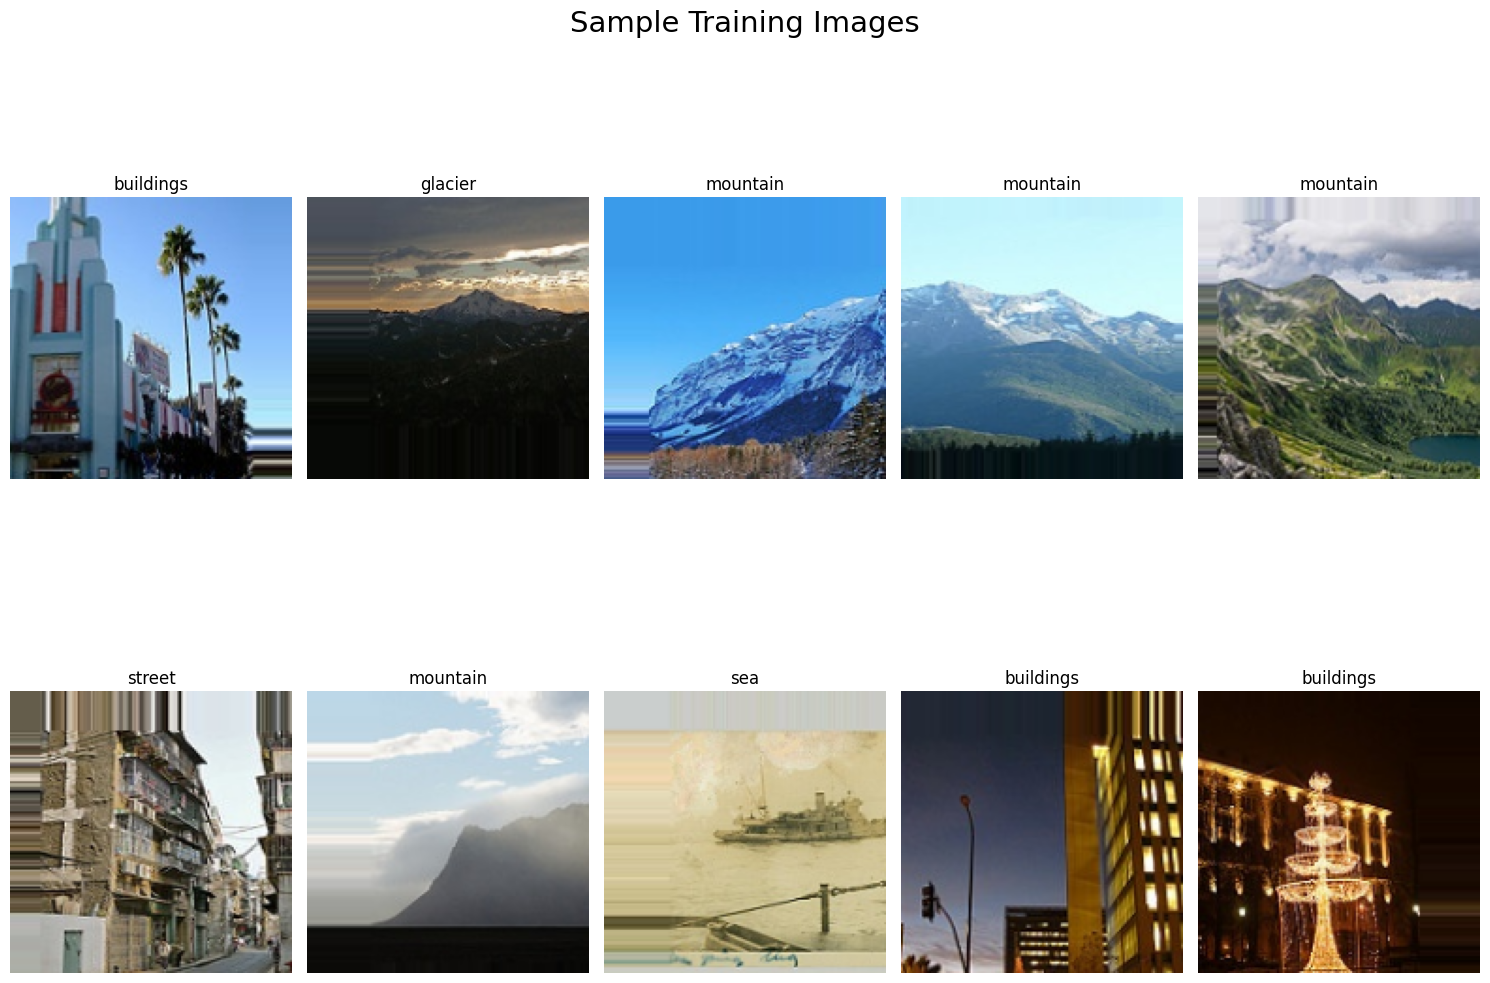

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [24]:
# Function to create the CNN model
def create_model():
    model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=(100, 100, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=128, activation='relu'),
        Dropout(0.5),
        
        Dense(units=6, activation='softmax')  # Assuming 6 classes
    ])
    
    return model

In [8]:
# Create CNN model
cnn_model = create_model()

In [9]:
print(cnn_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 146, 146, 128)  │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 146, 146, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 71, 71, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 71, 71, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 35, 35, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 33, 33, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 33, 33, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,201,830 (8.40 MB)

 Trainable params: 2,201,382 (8.40 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [40]:
# Learning rate scheduler and early stopping callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)


In [41]:
optimizer = Adam(learning_rate=0.001)

In [32]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
cnn_model.compile(
    optimizer=optimizer,
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [44]:
# Fit the model
history = cnn_model.fit(
    train_generator,
    epochs=20,  # Reduced number of epochs
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stop, checkpoint]
)


Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 719s 2s/step - accuracy: 0.9303 - loss: 0.2132 - val_accuracy: 0.8083 - val_loss: 0.7073 - learning_rate: 0.0010
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 663s 2s/step - accuracy: 0.9373 - loss: 0.1949 - val_accuracy: 0.7790 - val_loss: 0.7972 - learning_rate: 0.0010
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 651s 1s/step - accuracy: 0.9439 - loss: 0.1775 - val_accuracy: 0.8037 - val_loss: 0.8905 - learning_rate: 0.0010
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 652s 1s/step - accuracy: 0.9457 - loss: 0.1673 - val_accuracy: 0.6887 - val_loss: 1.2595 - learning_rate: 0.0010
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 654s 1s/step - accuracy: 0.9479 - loss: 0.1651 - val_accuracy: 0.7630 - val_loss: 1.0079 - learning_rate: 0.0010
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 655s 1s/step - accuracy: 0.9539 - loss: 0.1554 - val_accuracy: 0.7783 - val_loss: 1.1518 - learning_rate: 0.0010
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 652s 1s/step - accuracy: 0.9645 - loss: 0.

In [ ]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

# Plot the training history
plot_training_history(history)

In [66]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_data,
                                                 shuffle=True,
                                                 batch_size=32,
                                                 target_size = (150,150),
                                                 class_mode='categorical')

Found 3000 images belonging to 6 classes.


In [3]:
from tensorflow.keras.models import load_model

In [4]:
model=load_model('D:\\Virtual\\best_model.keras')

In [8]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [9]:
test_generator = test_datagen.flow_from_directory(
    test_data,
    target_size=(100, 100),  # Ensure this matches the input size of your model
    batch_size=64,  # Match the batch size used during training
    class_mode='categorical',
    shuffle=False  # Do not shuffle for consistent evaluation
)

Found 3000 images belonging to 6 classes.


In [10]:
predictions = model.predict(test_generator)

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step


In [19]:
predicted_classes = np.argmax(predictions, axis=1)

In [21]:
true_classes = test_generator.classes

# Class labels
class_labels = list(test_generator.class_indices.keys())

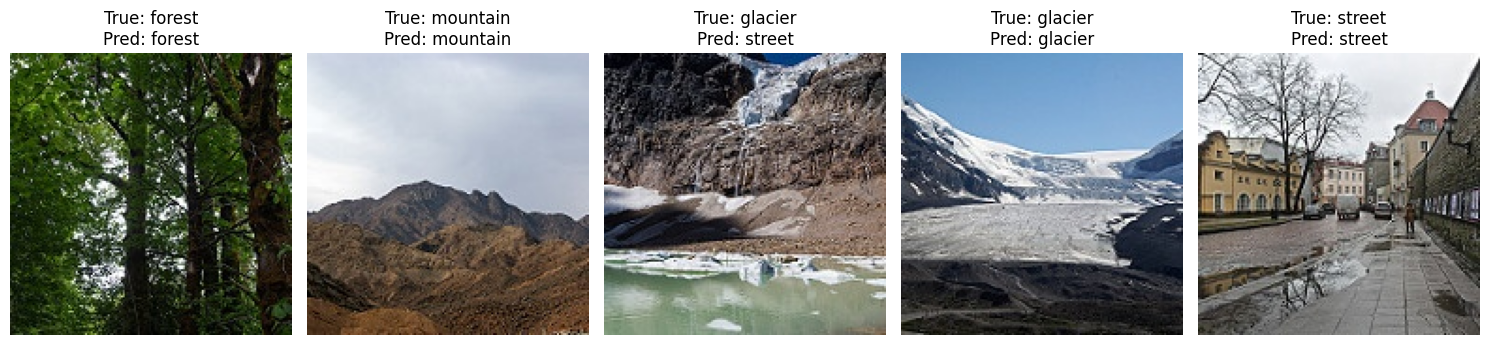

In [22]:
def plot_sample_predictions(test_generator, predictions, num_samples=5):
    """
    Function to plot sample images with predicted and true labels.
    
    Parameters:
    test_generator: ImageDataGenerator object for test data
    predictions: Predictions made by the model
    num_samples: Number of samples to visualize
    """
    # Randomly select sample indices
    sample_indices = np.random.choice(range(len(predictions)), num_samples, replace=False)
    
    # Plot the selected samples
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(sample_indices):
        # Load image and labels
        img_path = test_generator.filepaths[idx]
        img = plt.imread(img_path)
        
        # True and predicted labels
        true_label = class_labels[true_classes[idx]]
        predicted_label = class_labels[predicted_classes[idx]]
        
        # Display the image with labels
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize some predictions
plot_sample_predictions(test_generator, predicted_classes, num_samples=5)